<a href="https://colab.research.google.com/github/christyesmee/Thesis/blob/main/DataDownload.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data downloading

The Data Downloading process exists of two steps:
1. Downloading Sentinel-2A imagery
2. Downloading ontology features

## Webpages

The following web pages can be visited to gain a better understanding of the basic theory on the satellite bands and using Google Earth Engine.

* [Copernicus band description](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands)

* [EE Run Status](https://code.earthengine.google.com/tasks)

## Installing dependencies

In [ ]:
%%capture
!pip install SPARQLWrapper tqdm gdal
!pip install rasterio

In [ ]:
import ee
import pickle
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import os
import numpy as np
import torch
from SPARQLWrapper import SPARQLWrapper, JSON
from tqdm.notebook import trange
from osgeo import gdal

## Defining paths

In [ ]:
from google.colab import drive

drive_path = "/content/drive"
drive.mount(drive_path)

Mounted at /content/drive


# 1. Downloading Sentinel-2A imagery (2017)

### Defining paths

In [ ]:
# File path setup
img_dir = "17_sat_tif"  # The folder where you want to save the .tif files of the satelite images in
folder_path = f"{drive_path}/MyDrive/{img_dir}"

# Image path & scale for Sentinel-2A download
file_name = "galicia_split_image"  # Name of the .tif file
file_path = f"{folder_path}/{file_name}"
scale = 10  # pixels per meter

# Feature ontology path
ont_dir = "ont_pickles"
folder_path_ont = f"{drive_path}/MyDrive/{ont_dir}"
file_name_ont = "ont_features"
file_path_ont = f"{folder_path_ont}/{file_name_ont}"

### Google Earth Engine
The first step is to create an account in Google Cloud and create a project within an organization.

In [ ]:
# Trigger the authentication flow
ee.Authenticate()

# Initialize the library
ee.Initialize(project="christyesmee")  # this is the projectid

### Defining Satellite, Bands and AOI

In the step below you can change the bands you want to download for the image. If you want to get other bands then the ones used below, you can check out this webpage to see what bands are available to download for the Sentinel-2A imagery:  https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands

In [ ]:
# Select bands (RGB and NIR) and calculate NDVI
def preprocess(image):
    # Normalize bands and calculate NDVI
    ndvi = image.normalizedDifference(["B8", "B4"]).rename("NDVI")

    # Select and rename bands
    bands = image.select(["B4", "B3", "B2", "B8"], ["Red", "Green", "Blue", "NIR"])

    # Stack bands and NDVI, cast all to Float32
    bands = bands.addBands(ndvi).toFloat()

    return bands

In [ ]:
# function calculation is WRONG, Galicia has total surface of 29574 km^2
# function calculates: Area: 186.97km²
def get_area_roots(aoi):
    aoi_area = aoi.area(maxError=1)
    total_meters = aoi_area.getInfo()
    print(f'total meters =', {total_meters})
    m_root = math.sqrt(total_meters)
    km_root = m_root / 1_000
    print(f"--> Area: {round(km_root, 2):_}km²")
    return m_root, km_root

In [ ]:
# Define a Rectangle object.
rectangle = ee.Geometry.Rectangle(-122.09, 37.42, -122.08, 37.43)

# Apply the area method to the Rectangle object.
rectangle_area = rectangle.area(maxError=1)

# Print the result.
display('rectangle.area(...) =', rectangle_area)

# Display relevant geometries on the map.
m = geemap.Map()
m.set_center(-122.085, 37.422, 15)
m.add_layer(rectangle, {'color': 'black'}, 'Geometry [black]: rectangle')
m

In [ ]:
import geemap

# Define a Rectangle object.
# rectangle = ee.Geometry.Rectangle(-122.09, 37.42, -122.08, 37.43)
top_left, top_right = (43.308103, -8.599948), (43.308103, -6.711535)
bot_left, bot_right = (41.797418, -8.599948), (41.797418, -6.711535)
rectangle = ee.Geometry.Rectangle([top_left[1], top_left[0], bot_right[1], bot_right[0]])


# Apply the area method to the Rectangle object.
rectangle_area = rectangle.area(maxError=1)
rectangle_get_info = rectangle.getInfo()
rectangle_perimeter = rectangle.perimeter(maxError=1)
rectangle_area = rectangle.area(maxError=1)

# Print the result.
display('rectangle.area(...) =', rectangle_area)
display('rectangle.perimeter(...) =', rectangle_perimeter)
display('rectangle.area(...) =', rectangle_area)

# Display relevant geometries on the map.
m = geemap.Map()
m.set_center(-7.69372, 42.308103, 5)
m.add_layer(rectangle, {'color': 'black'}, 'Geometry [black]: rectangle')
m

'rectangle.area(...) ='

'rectangle.perimeter(...) ='

'rectangle.area(...) ='

Map(center=[42.308103, -7.69372], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Searc…

In [ ]:
import math

# Coordinates defined for the rectangle
x1, x2 = -8.599948, -6.711535  # longitudes
y1, y2 = 41.797418, 43.308103  # latitudes

# Average latitude
average_latitude = (y1 + y2) / 2

# Convert average latitude to radians for cosine calculation
average_latitude_radians = math.radians(average_latitude)

# Calculate the area in square kilometers
area_km2 = abs(x2 - x1) * abs(y2 - y1) * math.cos(average_latitude_radians) * 111.32 ** 2
area_km2


26042.422606475284

Some info to remember about latitudes and longitudes:


Latitude vs Longitude

< West to East > == Latitude (from "latus", side)

 -90 to 90 (0 over greenwitch)

< North to South > == Longitude (from "longus", length)

 90 to -90 (0 at equator)



What is used for Galicia is this:

GALICIA

Latitude: -8.599948 to -6.711535

Longitude: 41.797418 to 43.308103

<top-right>               <top-left>

43.308103, -8.599948)    (43.308103, -6.711535)

41.797418, -8.599948)    (41.797418, -6.711535)

<bot-right> <bot-left>


In [ ]:
# Name of satellite
sat_name = "COPERNICUS/S2_HARMONIZED"
cloud_filter = ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20)  # Less than 20% cloud cover

# Define the Area of Interest as a rectangle around Galicia, Spain
top_left, top_right = (43.308103, -8.599948), (43.308103, -6.711535)
bot_left, bot_right = (41.797418, -8.599948), (41.797418, -6.711535)
aoi = ee.Geometry.Rectangle([top_left[0], top_left[1], bot_right[0], bot_right[1]])
get_area_roots(aoi)

# Extract data
date_0 = "2017-01-01"
date_1 = "2017-12-30"

# Split image into slices -- have to split cuz we can only download until a certain amount of pixels per batch
slices = 7
factor = (bot_right[0] - top_left[0]) / slices
x_coords = [bot_right[1] + (factor * i) for i in range(slices + 1)]
y_coords = [top_left[0] + (factor * i) for i in range(slices + 1)]
print(f"--> {x_coords} ({len(x_coords)}), delta: {x_coords[-1]-x_coords[0]}")
print(f"--> {y_coords} ({len(y_coords)}), delta: {y_coords[-1]-y_coords[0]}")
print(f"--> top-left: {x_coords[0]}, {y_coords[-1]}")
print(f"--> bot-right: {x_coords[-1]}, {y_coords[0]}")

--> Area: 186.97km²
--> [-6.711535, -6.927347142857143, -7.143159285714286, -7.358971428571429, -7.574783571428572, -7.790595714285716, -8.00640785714286, -8.222220000000002] (8), delta: -1.5106850000000023
--> [43.308103, 43.09229085714286, 42.87647871428572, 42.66066657142857, 42.44485442857143, 42.229042285714286, 42.01323014285715, 41.797418] (8), delta: -1.5106850000000023
--> top-left: -6.711535, 41.797418
--> bot-right: -8.222220000000002, 43.308103


### Downloading and splitting images

Before executing the following, go to this webpage to start the google task manager and follow the progress of downloading the images from google ee: https://code.earthengine.google.com/tasks

It may take a while before the images will show up in your folder. You can keep track of this progress in the task manager.

In [ ]:
# Image splitting
print("\n ------------------------------------------------- \n")
info_dict = {}
tasks = []
for idx in range(len(x_coords) - 1):
    (
        x_start_i,
        x_end_i,
    ) = (
        x_coords[idx],
        x_coords[idx + 1],
    )
    print(f"--> {x_start_i}, {x_end_i}")
    for jdx in range(len(x_coords) - 1):
        y_start_i, y_end_i = y_coords[jdx], y_coords[jdx + 1]
        print(f"--> {y_start_i}, {y_end_i}")

        split_name = f"{file_name}_{idx}_{jdx}"
        print(f"--> {split_name}")

        # Get geom
        aoi_temp = ee.Geometry.Rectangle([x_start_i, y_start_i, x_end_i, y_end_i])
        get_area_roots(aoi_temp)
        info_dict[(idx, jdx)] = ((x_start_i, y_start_i), (x_end_i, y_end_i))

        # Get data
        landsat = (
            ee.ImageCollection(sat_name)
            .select(["B4", "B3", "B2", "B8"])  # R G B NIR
            .filterBounds(aoi_temp)
            .filterDate(date_0, date_1)
            .filter(cloud_filter)
        )

        # Make necessary edits to data
        preprocessed = landsat.map(preprocess)

        # Prepare for image output
        image = preprocessed.mean()
        image = image.clip(aoi_temp)

        task = ee.batch.Export.image.toDrive(
            image=image,
            description=split_name,
            fileNamePrefix=split_name,
            folder=img_dir,
            scale=scale,
            region=aoi_temp,
            fileFormat="GeoTIFF",
        )

        print(f"Export task started... ")
        task.start()
        tasks.append(task)
        print("\n")


 ------------------------------------------------- 

--> -6.711535, -6.927347142857143
--> 43.308103, 43.09229085714286
--> galicia_split_image_0_0
--> Area: 20.49km²
Export task started... 


--> 43.09229085714286, 42.87647871428572
--> galicia_split_image_0_1
--> Area: 20.52km²
Export task started... 


--> 42.87647871428572, 42.66066657142857
--> galicia_split_image_0_2
--> Area: 20.56km²
Export task started... 


--> 42.66066657142857, 42.44485442857143
--> galicia_split_image_0_3
--> Area: 20.6km²
Export task started... 


--> 42.44485442857143, 42.229042285714286
--> galicia_split_image_0_4
--> Area: 20.63km²
Export task started... 


--> 42.229042285714286, 42.01323014285715
--> galicia_split_image_0_5
--> Area: 20.67km²
Export task started... 


--> 42.01323014285715, 41.797418
--> galicia_split_image_0_6
--> Area: 20.7km²
Export task started... 


--> -6.927347142857143, -7.143159285714286
--> 43.308103, 43.09229085714286
--> galicia_split_image_1_0
--> Area: 20.49km²
Export 

### Saving metadata

Now we need to save the metadata of the tif images in a pickle format to be able to access the info easily.

Metadata: all meaurements of coordinates for each .tif tile

**IMPORTANT!!! **

Only execute when the all tasks in the task manager are fully executed.

In [ ]:
# Save image info
file_path_info = f"{file_path}.pickle"
with open(file_path_info, "wb") as f:
    pickle.dump(info_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

print(file_path)
# Load image info
file_path_info = f"{file_path}.pickle"
with open(file_path_info, "rb") as f:
    test = pickle.load(f)
print(test)

/content/drive/MyDrive/17_sat_tif/galicia_split_image
{(0, 0): ((-6.711535, 43.308103), (-6.927347142857143, 43.09229085714286)), (0, 1): ((-6.711535, 43.09229085714286), (-6.927347142857143, 42.87647871428572)), (0, 2): ((-6.711535, 42.87647871428572), (-6.927347142857143, 42.66066657142857)), (0, 3): ((-6.711535, 42.66066657142857), (-6.927347142857143, 42.44485442857143)), (0, 4): ((-6.711535, 42.44485442857143), (-6.927347142857143, 42.229042285714286)), (0, 5): ((-6.711535, 42.229042285714286), (-6.927347142857143, 42.01323014285715)), (0, 6): ((-6.711535, 42.01323014285715), (-6.927347142857143, 41.797418)), (1, 0): ((-6.927347142857143, 43.308103), (-7.143159285714286, 43.09229085714286)), (1, 1): ((-6.927347142857143, 43.09229085714286), (-7.143159285714286, 42.87647871428572)), (1, 2): ((-6.927347142857143, 42.87647871428572), (-7.143159285714286, 42.66066657142857)), (1, 3): ((-6.927347142857143, 42.66066657142857), (-7.143159285714286, 42.44485442857143)), (1, 4): ((-6.92734

# 2. Downloading Ontology Features

### Normalising functions

These functions are to normalise the values of the features so it can be processed to torch tensors in the data processing stage.

In [ ]:
def convert_to_num(col):
    col = pd.to_numeric(col, errors="coerce")
    col = col.fillna(-1).astype(float)
    col = col.astype(float)
    return col


def normalise_column(col):
    col = (col - col.min()) / (col.max() - col.min())
    return col

### Downloading the features

The code below will download the features from the Crossforest Ontology.  

In [ ]:
# # Patch 1: x_range = (-8.599948, -8.311216), y_range = (41.797418, 42.199285)  --> 3010
#        ?xvalue >= -8.599948 && ?xvalue <= -7.655742 &&
#        ?yvalue >= 41.797418 && ?yvalue <= 42.552761
# # Patch 2: x_range = (-8.599948, -8.311216), y_range = (42.199285, 42.333241)  --> 2069
#        ?xvalue >= -8.599948 && ?xvalue <= -7.655742 &&
#        ?yvalue >= 42.552761 && ?yvalue <= 43.308103
# # Patch 3: x_range = (-8.311216, -8.022484), y_range = (41.797418, 42.199285)  --> 2973
#        ?xvalue >= -7.655742 && ?xvalue <= -6.711535 &&
#        ?yvalue >= 41.797418 && ?yvalue <= 42.552761
# # Patch 4: x_range = (-8.311216, -8.022484), y_range = (42.199285, 42.333241)  --> 2285
#        ?xvalue >= -7.655742 && ?xvalue <= -6.711535 &&
#        ?yvalue >= 42.552761 && ?yvalue <= 43.308103

In [ ]:
# Set up the SPARQL connection
sparql = SPARQLWrapper("https://crossforest.gsic.uva.es/sparql")

# Manually set the offset for each execution
offset = 0  # Change this manually for each batch you want to retrieve; offset will start from the specified number
patch = 3

# Define the query with the current offset
optimised_query = f"""
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX pos: <http://crossforest.eu/position/ontology/>
    PREFIX epsg: <http://epsg.w3id.org/ontology/axis/>
    PREFIX ifn: <https://datos.iepnb.es/def/sector-publico/medio-ambiente/ifn/>
    PREFIX taxon: <https://datos.iepnb.es/recurso/sector-publico/medio-ambiente/pliniancore/>

    SELECT DISTINCT ?tree ?height ?firewood ?xvalue ?yvalue ?info
    WHERE {{
      ?tree rdf:type ifn:Tree ;
          rdf:type ?info ;
          ifn:hasTotalHeightInMeters ?height ;
          ifn:hasVolumeFirewoodInM3 ?firewood ;
          pos:hasPosition ?position .

     ?position epsg:107 ?xvalue ;
                epsg:106 ?yvalue .

    FILTER (
      ?xvalue >= -7.655742 && ?xvalue <= -6.711535 &&
      ?yvalue >= 41.797418 && ?yvalue <= 42.552761
       )
    }}
"""

# Set the query to the endpoint and set the return format to JSON
sparql.setQuery(optimised_query)
sparql.setReturnFormat(JSON)

# Execute the query and convert the result to a dictionary
results = sparql.query().convert()

# Convert the JSON to DataFrame
data = pd.json_normalize(results["results"]["bindings"])
data = data.applymap(lambda x: x["value"] if isinstance(x, dict) else x)

# Save this batch to a pickle file in the directory
pickle_filename = f"/content/drive/MyDrive/17_ont_pickles/data_batch_patch_{patch}.pkl"
data.to_pickle(pickle_filename)


In [ ]:
import pandas as pd
import glob

# Initialize an empty DataFrame to store the combined data
all_data = pd.DataFrame()

# Get a list of all pickle files in the directory
pickle_files = glob.glob("/content/drive/MyDrive/17_ont_pickles/batch/data_batch_patch_*.pkl")

# Load each pickle file and concatenate them into the all_data DataFrame
for pickle_file in pickle_files:
    batch_data = pd.read_pickle(pickle_file)
    all_data = pd.concat([all_data, batch_data], ignore_index=True)

# Now all_data contains all the data from the separate pickle files
# print(all_data)

In [ ]:
print(all_data.columns)

Index(['tree.type', 'tree.value', 'height.type', 'height.datatype',
       'height.value', 'firewood.type', 'firewood.datatype', 'firewood.value',
       'xvalue.type', 'xvalue.datatype', 'xvalue.value', 'yvalue.type',
       'yvalue.datatype', 'yvalue.value', 'info.type', 'info.value'],
      dtype='object')


In [ ]:
# Count rows with 'Species' in 'info.value'
species_count = all_data['info.value'].str.contains('Species').sum()

print(species_count)

70249


In [ ]:
ont_dir = "17_ont_pickles"
folder_path_ont = f"{drive_path}/MyDrive/{ont_dir}"
file_name_ont = "ont_features"
file_path_ont = f"{folder_path_ont}/{file_name_ont}"
slices = 7

In [ ]:
# Load image info
file_path = "/content/drive/MyDrive/17_sat_tif/galicia_split_image"
file_path_info = f"{file_path}.pickle"
with open(file_path_info, "rb") as f:
    coord_dict = pickle.load(f)
print(coord_dict)

{(0, 0): ((-6.711535, 43.308103), (-6.927347142857143, 43.09229085714286)), (0, 1): ((-6.711535, 43.09229085714286), (-6.927347142857143, 42.87647871428572)), (0, 2): ((-6.711535, 42.87647871428572), (-6.927347142857143, 42.66066657142857)), (0, 3): ((-6.711535, 42.66066657142857), (-6.927347142857143, 42.44485442857143)), (0, 4): ((-6.711535, 42.44485442857143), (-6.927347142857143, 42.229042285714286)), (0, 5): ((-6.711535, 42.229042285714286), (-6.927347142857143, 42.01323014285715)), (0, 6): ((-6.711535, 42.01323014285715), (-6.927347142857143, 41.797418)), (1, 0): ((-6.927347142857143, 43.308103), (-7.143159285714286, 43.09229085714286)), (1, 1): ((-6.927347142857143, 43.09229085714286), (-7.143159285714286, 42.87647871428572)), (1, 2): ((-6.927347142857143, 42.87647871428572), (-7.143159285714286, 42.66066657142857)), (1, 3): ((-6.927347142857143, 42.66066657142857), (-7.143159285714286, 42.44485442857143)), (1, 4): ((-6.927347142857143, 42.44485442857143), (-7.143159285714286, 4

In [ ]:
# Define the Area of Interest as a rectangle around Galicia, Spain
top_left, top_right = (43.308103, -8.599948), (43.308103, -6.711535)
bot_left, bot_right = (41.797418, -8.599948), (41.797418, -6.711535)
#aoi = ee.Geometry.Rectangle([top_left[0], top_left[1], bot_right[0], bot_right[1]])

# Split image into slices -- have to split cuz we can only download until a certain amount of pixels per batch
slices = 7
factor = (bot_right[0] - top_left[0]) / slices
x_coords = [bot_right[1] + (factor * i) for i in range(slices + 1)]
y_coords = [top_left[0] + (factor * i) for i in range(slices + 1)]
print(f"--> {x_coords} ({len(x_coords)}), delta: {x_coords[-1]-x_coords[0]}")
print(f"--> {y_coords} ({len(y_coords)}), delta: {y_coords[-1]-y_coords[0]}")
print(f"--> top-left: {x_coords[0]}, {y_coords[-1]}")
print(f"--> bot-right: {x_coords[-1]}, {y_coords[0]}")

--> [-6.711535, -6.927347142857143, -7.143159285714286, -7.358971428571429, -7.574783571428572, -7.790595714285716, -8.00640785714286, -8.222220000000002] (8), delta: -1.5106850000000023
--> [43.308103, 43.09229085714286, 42.87647871428572, 42.66066657142857, 42.44485442857143, 42.229042285714286, 42.01323014285715, 41.797418] (8), delta: -1.5106850000000023
--> top-left: -6.711535, 41.797418
--> bot-right: -8.222220000000002, 43.308103


In [ ]:
# Clean all_data
pd.set_option("display.max_colwidth", None)
all_data = all_data.drop_duplicates(subset="tree.value", keep="first")
all_data = all_data.drop(
    [
        "tree.type",
        "tree.value",
        "height.type",
        "height.datatype",
        "firewood.type",
        "firewood.datatype",
        "xvalue.type",
        "xvalue.datatype",
        "yvalue.type",
        "yvalue.datatype",
        "info.type",
    ],
    axis=1,
)
all_data = all_data.reset_index(drop=True)

# Rename cols
all_data = all_data.rename(
    columns={
        "xvalue.value": "xcoord",
        "yvalue.value": "ycoord",
        "height.value": "height",
        "firewood.value": "firewood",
        "info.value": "species_uri",
    }
)

# Delete all other rows that have other values than species
pattern = r"^https://datos\.iepnb\.es/def/sector-publico/medio-ambiente/ifn/Species\d+$"
all_data = all_data[all_data["species_uri"].str.match(pattern)]
all_data = all_data.copy()

# Change all strings into integers for species
all_data["species_number"] = (
    all_data["species_uri"].str.extract(r"Species(\d+)$").astype(int)
)
all_data = all_data.drop(["species_uri"], axis=1)

# Make all data numerical
all_data = all_data.apply(convert_to_num, axis=1)

# # Normalise values between 0 and 1
# all_data["height"] = normalise_column(all_data["height"])
# all_data["firewood"] = normalise_column(all_data["firewood"])
# all_data["species_number"] = normalise_column(all_data["species_number"])

In [ ]:
# Define the path
path = '/content/drive/MyDrive/17_ont_pickles/all_data_cleaned_no_norm.pickle'

# Save the DataFrame to the specified path
all_data.to_pickle(path)

print(f"DataFrame saved to {path}")

DataFrame saved to /content/drive/MyDrive/17_ont_pickles/all_data_cleaned_no_norm.pickle


In [ ]:
print(f"Longitude range in data: {all_data['xcoord'].min()} to {all_data['xcoord'].max()}")
print(f"Latitude range in data: {all_data['ycoord'].min()} to {all_data['ycoord'].max()}")


Longitude range in data: -8.599905 to -6.711556
Latitude range in data: 41.825591 to 43.307702


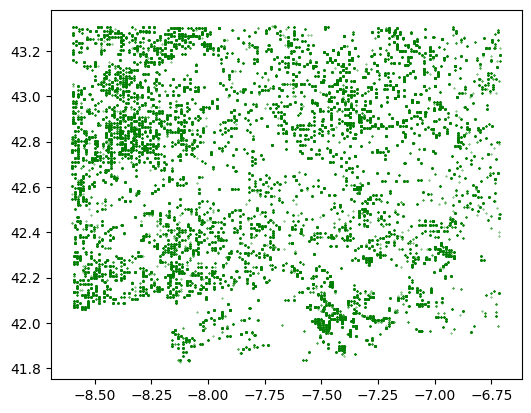

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming your data is already in a DataFrame `data`
gdf = gpd.GeoDataFrame(all_data, geometry=gpd.points_from_xy(all_data.xcoord, all_data.ycoord))

# Plot
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='green', markersize=0.1)
plt.show()


In [ ]:
import pandas as pd
import pickle
import folium

# Load the pickle file
#path = '/content/drive/MyDrive/17_ont_pickles/all_data_cleaned.pickle'
path = '/content/drive/MyDrive/17_ont_pickles/all_data_cleaned_no_norm.pickle'

with open(path, 'rb') as f:
    data = pickle.load(f)

# Assuming data is a DataFrame with columns for coordinates
# If the structure is different, you might need to adjust this part accordingly
df = pd.DataFrame(data)

# Check the first few rows of the dataframe to understand its structure
print(df[800:850])

     height    firewood    xcoord     ycoord  species_number
816    15.5    0.610317 -8.481150  42.116050            26.0
817    27.5  152.923641 -8.481065  42.116110            26.0
818    22.0    7.709893 -8.481083  42.116074            26.0
819    16.0  144.029132 -8.539517  42.377477            41.0
820     7.0   21.480421 -8.539609  42.377423            41.0
821    17.5   51.754700 -8.539657  42.377376            41.0
822    16.5   25.368935 -8.539664  42.377343            41.0
823     9.5    0.000000 -8.539696  42.377357            41.0
824    15.5    9.430017 -8.539727  42.377364            41.0
826     7.5    9.718874 -8.039768  42.509313           657.0
827     7.0    9.833070 -8.039770  42.509317           657.0
828    16.5   26.637731 -8.039820  42.509531            26.0
829    18.0    1.054359 -7.979951  42.445838            26.0
830    13.0   26.035644 -7.980056  42.445836            41.0
831    17.0   41.164877 -7.980189  42.445903            41.0
832    18.5  107.531521 

In [ ]:
# table with ontology overview for different species and their names:

# number of trees for the AOI
# species number # species name # amount

In [ ]:
# graph grid with all 6,6 tiles and a number of trees of the ontology for each tile
# table with

In [ ]:
# figure with original image, mask image, predicted mask image
# original sentinel 2017, ndvi 2018 true, ndvi 2018 predicted

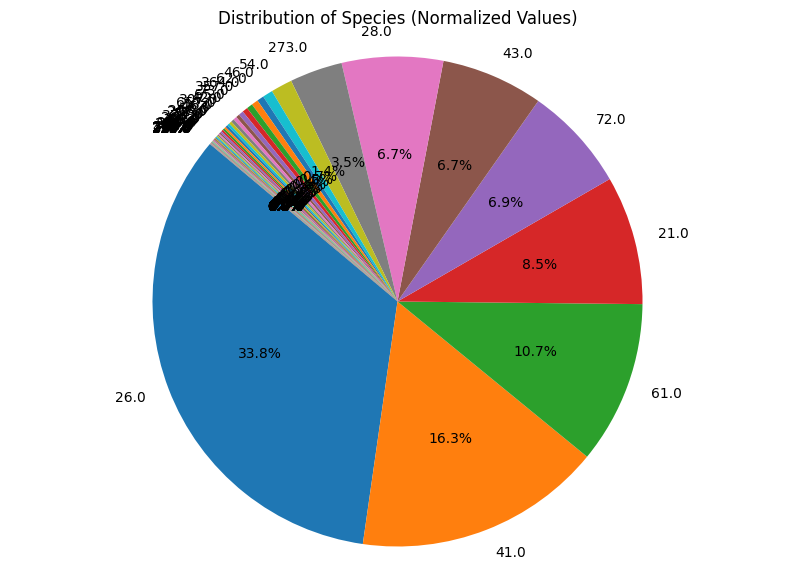

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame from the pickle file
file_path_pandas = '/content/drive/MyDrive/17_ont_pickles/all_data_cleaned_no_norm.pickle'
data = pd.read_pickle(file_path_pandas)

# Create a pie chart for the 'species_number' column
species_counts = data['species_number'].value_counts(normalize=True)

# Plot the pie chart
plt.figure(figsize=(10, 7))
plt.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Species (Normalized Values)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Save the pie chart
plt.savefig('/content/drive/MyDrive/species_distribution_pie_chart.png')
plt.show()


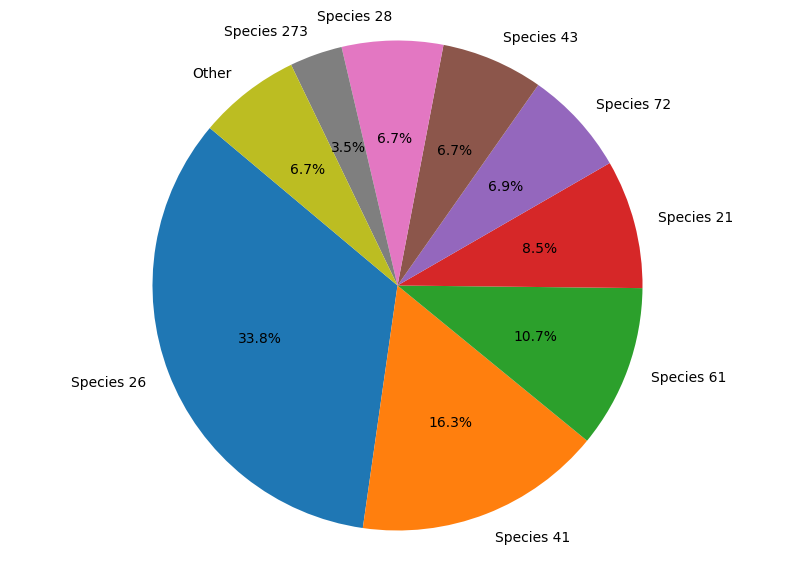

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame from the pickle file
file_path_pandas = '/content/drive/MyDrive/17_ont_pickles/all_data_cleaned_no_norm.pickle'
data = pd.read_pickle(file_path_pandas)

# Create a pie chart for the 'species_number' column
species_counts = data['species_number'].value_counts(normalize=True)

# Separate the 55 smallest classes and combine them into 'Other'
smallest_55_species = species_counts.nsmallest(62)
other_species = smallest_55_species.sum()

# Keep the remaining classes
remaining_species = species_counts.drop(smallest_55_species.index)

# Add the 'Other' class
remaining_species['Other'] = other_species

# Normalize the remaining_species series to ensure percentages are correct
remaining_species = remaining_species / remaining_species.sum()

# Convert index to strings with "Species X" format
labels = [f"Species {int(label)}" if label != 'Other' else 'Other' for label in remaining_species.index]

# Plot the pie chart
plt.figure(figsize=(10, 7))
plt.pie(remaining_species, labels=labels, autopct='%1.1f%%', startangle=140)
#plt.title('Distribution of Species (Top Classes + Other)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Save the pie chart
plt.savefig('/content/drive/MyDrive/species_distribution_pie_chart.png')
plt.show()


In [ ]:
import pandas as pd

# Step 1: Load the DataFrame
file_path_pandas = '/content/drive/MyDrive/17_ont_pickles/all_data_cleaned_no_norm.pickle'
all_data = pd.read_pickle(file_path_pandas)

# Step 2: Calculate Count and Percentage
species_count = all_data['species_number'].value_counts().reset_index()
species_count.columns = ['species_number', 'count']

total_count = species_count['count'].sum()
species_count['percentage'] = (species_count['count'] / total_count) * 100

species_count['species_normalised'] = species_count['species_number']  # Assuming species_number is already normalized

final_table = species_count[['species_normalised', 'count', 'percentage']]

# Add a total row
total_row = pd.DataFrame({
    'species_normalised': ['Total'],
    'count': [final_table['count'].sum()],
    'percentage': [final_table['percentage'].sum()]
})

final_table = pd.concat([final_table, total_row], ignore_index=True)

# Step 3: Display the Table
final_table


,species_normalised,count,percentage
0,26.0,22460,33.849771
1,41.0,10843,16.341633
2,61.0,7132,10.748734
3,21.0,5640,8.500121
4,72.0,4598,6.929708
...,...,...,...
66,29.0,1,0.001507
67,217.0,1,0.001507
68,96.0,1,0.001507
69,76.0,1,0.001507


In [ ]:
import pandas as pd

# Step 1: Load the DataFrame
file_path_pandas = '/content/drive/MyDrive/17_ont_pickles/all_data_cleaned_no_norm.pickle'
all_data = pd.read_pickle(file_path_pandas)

# Step 2: Calculate Count and Percentage
species_count = all_data['species_number'].value_counts().reset_index()
species_count.columns = ['species_number', 'count']

total_count = species_count['count'].sum()
species_count['percentage'] = (species_count['count'] / total_count) * 100

# Assuming species_number is already normalized
species_count['species_normalised'] = species_count['species_number']

# Create the final table with selected columns
final_table = species_count[['species_normalised', 'count', 'percentage']]

# Step 3: Add a total row
total_row = pd.DataFrame({
    'species_normalised': ['Total'],
    'count': [final_table['count'].sum()],
    'percentage': [final_table['percentage'].sum()]
})

# Append the total row to the final table
final_table = pd.concat([final_table, total_row], ignore_index=True)

# Step 4: Convert to LaTeX Table
latex_table = final_table.to_latex(index=False)

# Display the LaTeX table
print(latex_table)


\begin{tabular}{lrr}
\toprule
species_normalised & count & percentage \\
\midrule
26.000000 & 22460 & 33.849771 \\
41.000000 & 10843 & 16.341633 \\
61.000000 & 7132 & 10.748734 \\
21.000000 & 5640 & 8.500121 \\
72.000000 & 4598 & 6.929708 \\
43.000000 & 4468 & 6.733783 \\
28.000000 & 4430 & 6.676513 \\
273.000000 & 2310 & 3.481432 \\
54.000000 & 938 & 1.413673 \\
46.000000 & 443 & 0.667651 \\
62.000000 & 302 & 0.455148 \\
364.000000 & 291 & 0.438570 \\
357.000000 & 265 & 0.399385 \\
73.000000 & 237 & 0.357186 \\
65.000000 & 211 & 0.318001 \\
42.000000 & 157 & 0.236617 \\
307.000000 & 152 & 0.229081 \\
657.000000 & 138 & 0.207982 \\
58.000000 & 124 & 0.186882 \\
45.000000 & 111 & 0.167290 \\
68.000000 & 103 & 0.155233 \\
258.000000 & 86 & 0.129612 \\
207.000000 & 84 & 0.126598 \\
57.000000 & 83 & 0.125090 \\
74.000000 & 79 & 0.119062 \\
378.000000 & 62 & 0.093441 \\
264.000000 & 58 & 0.087413 \\
92.000000 & 57 & 0.085905 \\
95.000000 & 52 & 0.078370 \\
63.000000 & 48 & 0.072341 \\
25.00

In [ ]:
for idx in trange(slices):
    for jdx in trange(slices, leave=False):
        # this part works, correct: is getting the boundaries that are described in the coord_dict
        print(x_coords[jdx], x_coords[jdx+1])
        print(y_coords[jdx], y_coords[jdx+1])

        # enter the all_data and find the xmin and xmax, and ymin and ymax.
        filtered_data = all_data[
            (all_data['xcoord'] >= x_coords[jdx+1]) & (all_data['xcoord'] <= x_coords[jdx]) &
            (all_data['ycoord'] >= y_coords[jdx+1]) & (all_data['ycoord'] <= y_coords[jdx])
        ]
        print("Filtered Data:", filtered_data)

        # Save the filtered data to a pickle file
        file_path_pandas = f"{file_path_ont}_{idx}_{jdx}.pickle"
        filtered_data.to_pickle(file_path_pandas)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
Filtered Data:          height  firewood    xcoord     ycoord  species_number
51316  0.056604  0.000000 -6.861122  43.159796        0.091512
51317  0.396226  0.001242 -6.861242  43.159662        0.030504
51318  0.301887  0.003310 -6.861156  43.159764        0.091512
51319  0.301887  0.003103 -6.861154  43.159766        0.091512
51320  0.320755  0.021347 -6.861149  43.159772        0.091512
...         ...       ...       ...        ...             ...
70058  0.235849  0.000260 -6.911201  43.133717        0.023873
70059  0.198113  0.000085 -6.911239  43.133664        0.023873
70127  0.207547  0.000141 -6.911212  43.133846        0.023873
70128  0.207547  0.000114 -6.911207  43.133823        0.023873
70173  0.179245  0.001730 -6.725910  43.157125        0.051724

[587 rows x 5 columns]
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
Filtered Data:          height  firewood    xcoord     ycoord  species_num

  0%|          | 0/7 [00:00<?, ?it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
Filtered Data:          height  firewood    xcoord     ycoord  species_number
51316  0.056604  0.000000 -6.861122  43.159796        0.091512
51317  0.396226  0.001242 -6.861242  43.159662        0.030504
51318  0.301887  0.003310 -6.861156  43.159764        0.091512
51319  0.301887  0.003103 -6.861154  43.159766        0.091512
51320  0.320755  0.021347 -6.861149  43.159772        0.091512
...         ...       ...       ...        ...             ...
70058  0.235849  0.000260 -6.911201  43.133717        0.023873
70059  0.198113  0.000085 -6.911239  43.133664        0.023873
70127  0.207547  0.000141 -6.911212  43.133846        0.023873
70128  0.207547  0.000114 -6.911207  43.133823        0.023873
70173  0.179245  0.001730 -6.725910  43.157125        0.051724

[587 rows x 5 columns]
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
Filtered Data:          height  firewood    xcoord     ycoord  species_num

  0%|          | 0/7 [00:00<?, ?it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
Filtered Data:          height  firewood    xcoord     ycoord  species_number
51316  0.056604  0.000000 -6.861122  43.159796        0.091512
51317  0.396226  0.001242 -6.861242  43.159662        0.030504
51318  0.301887  0.003310 -6.861156  43.159764        0.091512
51319  0.301887  0.003103 -6.861154  43.159766        0.091512
51320  0.320755  0.021347 -6.861149  43.159772        0.091512
...         ...       ...       ...        ...             ...
70058  0.235849  0.000260 -6.911201  43.133717        0.023873
70059  0.198113  0.000085 -6.911239  43.133664        0.023873
70127  0.207547  0.000141 -6.911212  43.133846        0.023873
70128  0.207547  0.000114 -6.911207  43.133823        0.023873
70173  0.179245  0.001730 -6.725910  43.157125        0.051724

[587 rows x 5 columns]
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
Filtered Data:          height  firewood    xcoord     ycoord  species_num

  0%|          | 0/7 [00:00<?, ?it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
Filtered Data:          height  firewood    xcoord     ycoord  species_number
51316  0.056604  0.000000 -6.861122  43.159796        0.091512
51317  0.396226  0.001242 -6.861242  43.159662        0.030504
51318  0.301887  0.003310 -6.861156  43.159764        0.091512
51319  0.301887  0.003103 -6.861154  43.159766        0.091512
51320  0.320755  0.021347 -6.861149  43.159772        0.091512
...         ...       ...       ...        ...             ...
70058  0.235849  0.000260 -6.911201  43.133717        0.023873
70059  0.198113  0.000085 -6.911239  43.133664        0.023873
70127  0.207547  0.000141 -6.911212  43.133846        0.023873
70128  0.207547  0.000114 -6.911207  43.133823        0.023873
70173  0.179245  0.001730 -6.725910  43.157125        0.051724

[587 rows x 5 columns]
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
Filtered Data:          height  firewood    xcoord     ycoord  species_num

  0%|          | 0/7 [00:00<?, ?it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
Filtered Data:          height  firewood    xcoord     ycoord  species_number
51316  0.056604  0.000000 -6.861122  43.159796        0.091512
51317  0.396226  0.001242 -6.861242  43.159662        0.030504
51318  0.301887  0.003310 -6.861156  43.159764        0.091512
51319  0.301887  0.003103 -6.861154  43.159766        0.091512
51320  0.320755  0.021347 -6.861149  43.159772        0.091512
...         ...       ...       ...        ...             ...
70058  0.235849  0.000260 -6.911201  43.133717        0.023873
70059  0.198113  0.000085 -6.911239  43.133664        0.023873
70127  0.207547  0.000141 -6.911212  43.133846        0.023873
70128  0.207547  0.000114 -6.911207  43.133823        0.023873
70173  0.179245  0.001730 -6.725910  43.157125        0.051724

[587 rows x 5 columns]
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
Filtered Data:          height  firewood    xcoord     ycoord  species_num

  0%|          | 0/7 [00:00<?, ?it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
Filtered Data:          height  firewood    xcoord     ycoord  species_number
51316  0.056604  0.000000 -6.861122  43.159796        0.091512
51317  0.396226  0.001242 -6.861242  43.159662        0.030504
51318  0.301887  0.003310 -6.861156  43.159764        0.091512
51319  0.301887  0.003103 -6.861154  43.159766        0.091512
51320  0.320755  0.021347 -6.861149  43.159772        0.091512
...         ...       ...       ...        ...             ...
70058  0.235849  0.000260 -6.911201  43.133717        0.023873
70059  0.198113  0.000085 -6.911239  43.133664        0.023873
70127  0.207547  0.000141 -6.911212  43.133846        0.023873
70128  0.207547  0.000114 -6.911207  43.133823        0.023873
70173  0.179245  0.001730 -6.725910  43.157125        0.051724

[587 rows x 5 columns]
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
Filtered Data:          height  firewood    xcoord     ycoord  species_num

  0%|          | 0/7 [00:00<?, ?it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
Filtered Data:          height  firewood    xcoord     ycoord  species_number
51316  0.056604  0.000000 -6.861122  43.159796        0.091512
51317  0.396226  0.001242 -6.861242  43.159662        0.030504
51318  0.301887  0.003310 -6.861156  43.159764        0.091512
51319  0.301887  0.003103 -6.861154  43.159766        0.091512
51320  0.320755  0.021347 -6.861149  43.159772        0.091512
...         ...       ...       ...        ...             ...
70058  0.235849  0.000260 -6.911201  43.133717        0.023873
70059  0.198113  0.000085 -6.911239  43.133664        0.023873
70127  0.207547  0.000141 -6.911212  43.133846        0.023873
70128  0.207547  0.000114 -6.911207  43.133823        0.023873
70173  0.179245  0.001730 -6.725910  43.157125        0.051724

[587 rows x 5 columns]
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
Filtered Data:          height  firewood    xcoord     ycoord  species_num

In [ ]:
import pandas as pd
from tqdm import trange

# Assuming all_data, x_coords, y_coords, slices, and file_path_ont are already defined

# Create a list to store the results
results = []

# Loop through each tile
for idx in trange(slices, desc='X slices'):
    for jdx in trange(slices, leave=False, desc='Y slices'):
        # Get the boundaries for the current tile
        print(x_coords[jdx], x_coords[jdx+1])
        print(y_coords[jdx], y_coords[jdx+1])

        x_min, x_max = x_coords[jdx+1], x_coords[jdx]
        y_min, y_max = y_coords[jdx+1], y_coords[jdx]

        # Filter the data for the current tile
        filtered_data = all_data[
            (all_data['xcoord'] >= x_min) & (all_data['xcoord'] <= x_max) &
            (all_data['ycoord'] >= y_min) & (all_data['ycoord'] <= y_max)
        ]

        # Count the number of trees in the current tile
        tree_count = len(filtered_data)

        # Append the result to the results list
        results.append({'tile_x': idx, 'tile_y': jdx, 'tree_count': tree_count})

        # Save the filtered data to a pickle file
        file_path_pandas = f"{file_path_ont}_{idx}_{jdx}.pickle"
        filtered_data.to_pickle(file_path_pandas)

# Convert the results list to a DataFrame
summary_table = pd.DataFrame(results)

# Save the summary table as a CSV file
csv_path = '/content/drive/MyDrive/17_ont_pickles/summary_table.csv'
summary_table.to_csv(csv_path, index=False)

# Save the summary table as a NumPy array
np_path = '/content/drive/MyDrive/17_ont_pickles/summary_table.npy'
np.save(np_path, summary_table.values)

# Display the summary table
summary_table


X slices:  14%|█▍        | 1/7 [00:00<00:00,  6.30it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
-7.143159285714286 -7.358971428571429
42.87647871428572 42.66066657142857
-7.358971428571429 -7.574783571428572
42.66066657142857 42.44485442857143
-7.574783571428572 -7.790595714285716
42.44485442857143 42.229042285714286
-7.790595714285716 -8.00640785714286
42.229042285714286 42.01323014285715
-8.00640785714286 -8.222220000000002
42.01323014285715 41.797418



Y slices:   0%|          | 0/7 [00:00<?, ?it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
-7.143159285714286 -7.358971428571429
42.87647871428572 42.66066657142857



X slices:  29%|██▊       | 2/7 [00:00<00:00,  5.17it/s]

-7.358971428571429 -7.574783571428572
42.66066657142857 42.44485442857143
-7.574783571428572 -7.790595714285716
42.44485442857143 42.229042285714286
-7.790595714285716 -8.00640785714286
42.229042285714286 42.01323014285715
-8.00640785714286 -8.222220000000002
42.01323014285715 41.797418



Y slices:   0%|          | 0/7 [00:00<?, ?it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
-7.143159285714286 -7.358971428571429
42.87647871428572 42.66066657142857
-7.358971428571429 -7.574783571428572
42.66066657142857 42.44485442857143



X slices:  43%|████▎     | 3/7 [00:00<00:00,  4.98it/s]

-7.574783571428572 -7.790595714285716
42.44485442857143 42.229042285714286
-7.790595714285716 -8.00640785714286
42.229042285714286 42.01323014285715
-8.00640785714286 -8.222220000000002
42.01323014285715 41.797418



Y slices:   0%|          | 0/7 [00:00<?, ?it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
-7.143159285714286 -7.358971428571429
42.87647871428572 42.66066657142857
-7.358971428571429 -7.574783571428572
42.66066657142857 42.44485442857143
-7.574783571428572 -7.790595714285716
42.44485442857143 42.229042285714286



X slices:  57%|█████▋    | 4/7 [00:00<00:00,  5.00it/s]

-7.790595714285716 -8.00640785714286
42.229042285714286 42.01323014285715
-8.00640785714286 -8.222220000000002
42.01323014285715 41.797418



Y slices:   0%|          | 0/7 [00:00<?, ?it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
-7.143159285714286 -7.358971428571429
42.87647871428572 42.66066657142857
-7.358971428571429 -7.574783571428572
42.66066657142857 42.44485442857143



Y slices:  86%|████████▌ | 6/7 [00:00<00:00, 53.19it/s]


-7.574783571428572 -7.790595714285716
42.44485442857143 42.229042285714286
-7.790595714285716 -8.00640785714286
42.229042285714286 42.01323014285715
-8.00640785714286 -8.222220000000002
42.01323014285715 41.797418


Y slices:   0%|          | 0/7 [00:00<?, ?it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
-7.143159285714286 -7.358971428571429
42.87647871428572 42.66066657142857



Y slices:  43%|████▎     | 3/7 [00:00<00:00, 29.21it/s]

-7.358971428571429 -7.574783571428572
42.66066657142857 42.44485442857143



X slices:  86%|████████▌ | 6/7 [00:01<00:00,  5.11it/s]

-7.574783571428572 -7.790595714285716
42.44485442857143 42.229042285714286
-7.790595714285716 -8.00640785714286
42.229042285714286 42.01323014285715
-8.00640785714286 -8.222220000000002
42.01323014285715 41.797418



Y slices:   0%|          | 0/7 [00:00<?, ?it/s]

-6.711535 -6.927347142857143
43.308103 43.09229085714286
-6.927347142857143 -7.143159285714286
43.09229085714286 42.87647871428572
-7.143159285714286 -7.358971428571429
42.87647871428572 42.66066657142857
-7.358971428571429 -7.574783571428572
42.66066657142857 42.44485442857143



Y slices:  57%|█████▋    | 4/7 [00:00<00:00, 31.37it/s]

-7.574783571428572 -7.790595714285716
42.44485442857143 42.229042285714286
-7.790595714285716 -8.00640785714286
42.229042285714286 42.01323014285715
-8.00640785714286 -8.222220000000002
42.01323014285715 41.797418



X slices: 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


,tile_x,tile_y,tree_count
0,0,0,587
1,0,1,1665
2,0,2,942
3,0,3,444
4,0,4,1194
5,0,5,1018
6,0,6,662
7,1,0,587
8,1,1,1665
9,1,2,942


# 3. Downloading Sentinel-2A imagery (2018) -- Targets

## Defining paths

In [ ]:
# File path setup
img_dir = "18_sat_tif"  # The folder where you want to save the .tif files of the satelite images in
folder_path = f"{drive_path}/MyDrive/{img_dir}"

# Image path & scale for Sentinel-2A download
file_name = "galicia_split_image"  # Name of the .tif file
file_path = f"{folder_path}/{file_name}"
scale = 10  # pixels per meter

### Google Earth Engine
The first step is to create an account in Google Cloud and create a project within an organization.

In [ ]:
# Trigger the authentication flow
ee.Authenticate()

# Initialize the library
ee.Initialize(project="christyesmee")  # this is the projectid

### Defining Satellite, Bands and AOI

In the step below you can change the bands you want to download for the image. If you want to get other bands then the ones used below, you can check out this webpage to see what bands are available to download for the Sentinel-2A imagery:  https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands

In [ ]:
# Select bands (RGB and NIR) and calculate NDVI
def preprocess(image):
    # Normalize bands and calculate NDVI
    ndvi = image.normalizedDifference(["B8", "B4"]).rename("NDVI")

    # Select and rename bands
    bands = image.select(["B4", "B3", "B2", "B8"], ["Red", "Green", "Blue", "NIR"])

    # Stack bands and NDVI, cast all to Float32
    bands = bands.addBands(ndvi).toFloat()

    return bands

In [ ]:
# function calculation is WRONG, Galicia has total surface of 29574 km^2
# function calculates: Area: 186.97km²
def get_area_roots(aoi):
    aoi_area = aoi.area(maxError=1)
    total_meters = aoi_area.getInfo()
    m_root = math.sqrt(total_meters)
    km_root = m_root / 1_000
    print(f"--> Area: {round(km_root, 2):_}km²")
    return m_root, km_root

Some info to remember about latitudes and longitudes:


Latitude vs Longitude

< West to East > == Latitude (from "latus", side)

 -90 to 90 (0 over greenwitch)

< North to South > == Longitude (from "longus", length)

 90 to -90 (0 at equator)



What is used for Galicia is this:

GALICIA

Latitude: -8.599948 to -6.711535

Longitude: 41.797418 to 43.308103

<top-right>               <top-left>

43.308103, -8.599948)    (43.308103, -6.711535)

41.797418, -8.599948)    (41.797418, -6.711535)

<bot-right> <bot-left>


In [ ]:
# Name of satellite
sat_name = "COPERNICUS/S2_HARMONIZED"
cloud_filter = ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20)  # Less than 20% cloud cover

# Define the Area of Interest as a rectangle around Galicia, Spain
top_left, top_right = (43.308103, -8.599948), (43.308103, -6.711535)
bot_left, bot_right = (41.797418, -8.599948), (41.797418, -6.711535)
aoi = ee.Geometry.Rectangle([top_left[0], top_left[1], bot_right[0], bot_right[1]])
get_area_roots(aoi)

# Extract data
date_0 = "2018-01-01"
date_1 = "2018-12-30"

# Split image into slices -- have to split cuz we can only download until a certain amount of pixels per batch
slices = 7
factor = (bot_right[0] - top_left[0]) / slices
x_coords = [bot_right[1] + (factor * i) for i in range(slices + 1)]
y_coords = [top_left[0] + (factor * i) for i in range(slices + 1)]
print(f"--> {x_coords} ({len(x_coords)}), delta: {x_coords[-1]-x_coords[0]}")
print(f"--> {y_coords} ({len(y_coords)}), delta: {y_coords[-1]-y_coords[0]}")
print(f"--> top-left: {x_coords[0]}, {y_coords[-1]}")
print(f"--> bot-right: {x_coords[-1]}, {y_coords[0]}")

--> Area: 186.97km²
--> [-6.711535, -6.927347142857143, -7.143159285714286, -7.358971428571429, -7.574783571428572, -7.790595714285716, -8.00640785714286, -8.222220000000002] (8), delta: -1.5106850000000023
--> [43.308103, 43.09229085714286, 42.87647871428572, 42.66066657142857, 42.44485442857143, 42.229042285714286, 42.01323014285715, 41.797418] (8), delta: -1.5106850000000023
--> top-left: -6.711535, 41.797418
--> bot-right: -8.222220000000002, 43.308103


### Downloading and splitting images

Before executing the following, go to this webpage to start the google task manager and follow the progress of downloading the images from google ee: https://code.earthengine.google.com/tasks

It may take a while before the images will show up in your folder. You can keep track of this progress in the task manager.

In [ ]:
# Image splitting
print("\n ------------------------------------------------- \n")
info_dict = {}
tasks = []
for idx in range(len(x_coords) - 1):
    (
        x_start_i,
        x_end_i,
    ) = (
        x_coords[idx],
        x_coords[idx + 1],
    )
    print(f"--> {x_start_i}, {x_end_i}")
    for jdx in range(len(x_coords) - 1):
        y_start_i, y_end_i = y_coords[jdx], y_coords[jdx + 1]
        print(f"--> {y_start_i}, {y_end_i}")

        split_name = f"{file_name}_{idx}_{jdx}"
        print(f"--> {split_name}")

        # Get geom
        aoi_temp = ee.Geometry.Rectangle([x_start_i, y_start_i, x_end_i, y_end_i])
        get_area_roots(aoi_temp)
        info_dict[(idx, jdx)] = ((x_start_i, y_start_i), (x_end_i, y_end_i))

        # Get data
        landsat = (
            ee.ImageCollection(sat_name)
            .select(["B4", "B3", "B2", "B8"])  # R G B NIR
            .filterBounds(aoi_temp)
            .filterDate(date_0, date_1)
            .filter(cloud_filter)
        )

        # Make necessary edits to data
        preprocessed = landsat.map(preprocess)

        # Prepare for image output
        image = preprocessed.mean()
        image = image.clip(aoi_temp)

        task = ee.batch.Export.image.toDrive(
            image=image,
            description=split_name,
            fileNamePrefix=split_name,
            folder=img_dir,
            scale=scale,
            region=aoi_temp,
            fileFormat="GeoTIFF",
        )

        print(f"Export task started... ")
        task.start()
        tasks.append(task)
        print("\n")


 ------------------------------------------------- 

--> -6.711535, -6.927347142857143
--> 43.308103, 43.09229085714286
--> galicia_split_image_0_0
--> Area: 20.49km²
Export task started... 


--> 43.09229085714286, 42.87647871428572
--> galicia_split_image_0_1
--> Area: 20.52km²
Export task started... 


--> 42.87647871428572, 42.66066657142857
--> galicia_split_image_0_2
--> Area: 20.56km²
Export task started... 


--> 42.66066657142857, 42.44485442857143
--> galicia_split_image_0_3
--> Area: 20.6km²
Export task started... 


--> 42.44485442857143, 42.229042285714286
--> galicia_split_image_0_4
--> Area: 20.63km²
Export task started... 


--> 42.229042285714286, 42.01323014285715
--> galicia_split_image_0_5
--> Area: 20.67km²
Export task started... 


--> 42.01323014285715, 41.797418
--> galicia_split_image_0_6
--> Area: 20.7km²
Export task started... 


--> -6.927347142857143, -7.143159285714286
--> 43.308103, 43.09229085714286
--> galicia_split_image_1_0
--> Area: 20.49km²
Export 

# 4. Downloading Sentinel-2A imagery (2019)

i am trying to make a resunet model that will predict ndvi values for the year 2018.

is it possible that the features are bands and the labels is the score of the ndvi band per pixel?

should i give the satellite images of 2017 and the target labels of 2018 to predict for 2018?

## Defining paths

In [ ]:
# File path setup
img_dir = "19_sat_tif"  # The folder where you want to save the .tif files of the satelite images in
folder_path = f"{drive_path}/MyDrive/{img_dir}"

# Image path & scale for Sentinel-2A download
file_name = "galicia_split_image"  # Name of the .tif file
file_path = f"{folder_path}/{file_name}"
scale = 10  # pixels per meter

### Google Earth Engine
The first step is to create an account in Google Cloud and create a project within an organization.

In [ ]:
# Trigger the authentication flow
ee.Authenticate()

# Initialize the library
ee.Initialize(project="christyesmee")  # this is the projectid

### Defining Satellite, Bands and AOI

In the step below you can change the bands you want to download for the image. If you want to get other bands then the ones used below, you can check out this webpage to see what bands are available to download for the Sentinel-2A imagery:  https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands

In [ ]:
# Select bands (RGB and NIR) and calculate NDVI
def preprocess(image):
    # Normalize bands and calculate NDVI
    ndvi = image.normalizedDifference(["B8", "B4"]).rename("NDVI")

    # Select and rename bands
    bands = image.select(["B4", "B3", "B2", "B8"], ["Red", "Green", "Blue", "NIR"])

    # Stack bands and NDVI, cast all to Float32
    bands = bands.addBands(ndvi).toFloat()

    return bands

In [ ]:
# function calculation is WRONG, Galicia has total surface of 29574 km^2
# function calculates: Area: 186.97km²
def get_area_roots(aoi):
    aoi_area = aoi.area(maxError=1)
    total_meters = aoi_area.getInfo()
    m_root = math.sqrt(total_meters)
    km_root = m_root / 1_000
    print(f"--> Area: {round(km_root, 2):_}km²")
    return m_root, km_root

Some info to remember about latitudes and longitudes:


Latitude vs Longitude

< West to East > == Latitude (from "latus", side)

 -90 to 90 (0 over greenwitch)

< North to South > == Longitude (from "longus", length)

 90 to -90 (0 at equator)



What is used for Galicia is this:

GALICIA

Latitude: -8.599948 to -6.711535

Longitude: 41.797418 to 43.308103

<top-right>               <top-left>

43.308103, -8.599948)    (43.308103, -6.711535)

41.797418, -8.599948)    (41.797418, -6.711535)

<bot-right> <bot-left>


In [ ]:
# Name of satellite
sat_name = "COPERNICUS/S2_HARMONIZED"
cloud_filter = ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20)  # Less than 20% cloud cover

# Define the Area of Interest as a rectangle around Galicia, Spain
top_left, top_right = (43.308103, -8.599948), (43.308103, -6.711535)
bot_left, bot_right = (41.797418, -8.599948), (41.797418, -6.711535)
aoi = ee.Geometry.Rectangle([top_left[0], top_left[1], bot_right[0], bot_right[1]])
get_area_roots(aoi)

# Extract data
date_0 = "2019-01-01"
date_1 = "2019-12-30"

# Split image into slices -- have to split cuz we can only download until a certain amount of pixels per batch
slices = 7
factor = (bot_right[0] - top_left[0]) / slices
x_coords = [bot_right[1] + (factor * i) for i in range(slices + 1)]
y_coords = [top_left[0] + (factor * i) for i in range(slices + 1)]
print(f"--> {x_coords} ({len(x_coords)}), delta: {x_coords[-1]-x_coords[0]}")
print(f"--> {y_coords} ({len(y_coords)}), delta: {y_coords[-1]-y_coords[0]}")
print(f"--> top-left: {x_coords[0]}, {y_coords[-1]}")
print(f"--> bot-right: {x_coords[-1]}, {y_coords[0]}")

--> Area: 186.97km²
--> [-6.711535, -6.927347142857143, -7.143159285714286, -7.358971428571429, -7.574783571428572, -7.790595714285716, -8.00640785714286, -8.222220000000002] (8), delta: -1.5106850000000023
--> [43.308103, 43.09229085714286, 42.87647871428572, 42.66066657142857, 42.44485442857143, 42.229042285714286, 42.01323014285715, 41.797418] (8), delta: -1.5106850000000023
--> top-left: -6.711535, 41.797418
--> bot-right: -8.222220000000002, 43.308103


### Downloading and splitting images

Before executing the following, go to this webpage to start the google task manager and follow the progress of downloading the images from google ee: https://code.earthengine.google.com/tasks

It may take a while before the images will show up in your folder. You can keep track of this progress in the task manager.

In [ ]:
# Image splitting
print("\n ------------------------------------------------- \n")
info_dict = {}
tasks = []
for idx in range(len(x_coords) - 1):
    (
        x_start_i,
        x_end_i,
    ) = (
        x_coords[idx],
        x_coords[idx + 1],
    )
    print(f"--> {x_start_i}, {x_end_i}")
    for jdx in range(len(x_coords) - 1):
        y_start_i, y_end_i = y_coords[jdx], y_coords[jdx + 1]
        print(f"--> {y_start_i}, {y_end_i}")

        split_name = f"{file_name}_{idx}_{jdx}"
        print(f"--> {split_name}")

        # Get geom
        aoi_temp = ee.Geometry.Rectangle([x_start_i, y_start_i, x_end_i, y_end_i])
        get_area_roots(aoi_temp)
        info_dict[(idx, jdx)] = ((x_start_i, y_start_i), (x_end_i, y_end_i))

        # Get data
        landsat = (
            ee.ImageCollection(sat_name)
            .select(["B4", "B3", "B2", "B8"])  # R G B NIR
            .filterBounds(aoi_temp)
            .filterDate(date_0, date_1)
            .filter(cloud_filter)
        )

        # Make necessary edits to data
        preprocessed = landsat.map(preprocess)

        # Prepare for image output
        image = preprocessed.mean()
        image = image.clip(aoi_temp)

        task = ee.batch.Export.image.toDrive(
            image=image,
            description=split_name,
            fileNamePrefix=split_name,
            folder=img_dir,
            scale=scale,
            region=aoi_temp,
            fileFormat="GeoTIFF",
        )

        print(f"Export task started... ")
        task.start()
        tasks.append(task)
        print("\n")


 ------------------------------------------------- 

--> -6.711535, -6.927347142857143
--> 43.308103, 43.09229085714286
--> galicia_split_image_0_0
--> Area: 20.49km²
Export task started... 


--> 43.09229085714286, 42.87647871428572
--> galicia_split_image_0_1
--> Area: 20.52km²
Export task started... 


--> 42.87647871428572, 42.66066657142857
--> galicia_split_image_0_2
--> Area: 20.56km²
Export task started... 


--> 42.66066657142857, 42.44485442857143
--> galicia_split_image_0_3
--> Area: 20.6km²
Export task started... 


--> 42.44485442857143, 42.229042285714286
--> galicia_split_image_0_4
--> Area: 20.63km²
Export task started... 


--> 42.229042285714286, 42.01323014285715
--> galicia_split_image_0_5
--> Area: 20.67km²
Export task started... 


--> 42.01323014285715, 41.797418
--> galicia_split_image_0_6
--> Area: 20.7km²
Export task started... 


--> -6.927347142857143, -7.143159285714286
--> 43.308103, 43.09229085714286
--> galicia_split_image_1_0
--> Area: 20.49km²
Export 

# OLD

In [ ]:
slices = 7
for idx in trange(slices):
    for jdx in trange(slices, leave=False):
        print(x_coords[jdx], x_coords[jdx + 1])       ## uncomment these two print statements if you want to see what coordinates for each image are used
        print(y_coords[jdx], y_coords[jdx + 1])
        sparql = SPARQLWrapper("https://crossforest.gsic.uva.es/sparql")

        optimised_query = f"""
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX pos: <http://crossforest.eu/position/ontology/>
        PREFIX epsg: <http://epsg.w3id.org/ontology/axis/>
        PREFIX ifn: <https://datos.iepnb.es/def/sector-publico/medio-ambiente/ifn/>
        PREFIX taxon: <https://datos.iepnb.es/recurso/sector-publico/medio-ambiente/pliniancore/>

        SELECT DISTINCT ?tree ?height ?firewood ?xvalue ?yvalue ?info
        WHERE {{
          ?tree rdf:type ifn:Tree ;
              rdf:type ?info ;
              ifn:hasTotalHeightInMeters ?height ;
              ifn:hasVolumeFirewoodInM3 ?firewood ;
              pos:hasPosition ?position .

         ?position epsg:107 ?xvalue ;
                    epsg:106 ?yvalue .

        FILTER (
           ?xvalue >= -8.599948 && ?xvalue <= -8.022484 &&
           ?yvalue >= 41.797418 && ?yvalue <= 42.333241 &&
            regex(str(?info), "Species\\\\d+$")
           )
}}
LIMIT 1000 OFFSET 0
"""

        # Set the query to the endpoint and set the return format to JSON
        sparql.setQuery(optimised_query)
        sparql.setReturnFormat(JSON)

        # Execute the query and convert the result to a dictionary
        results = sparql.query().convert()

        # Convert the JSON to DataFrame
        data = pd.json_normalize(results["results"]["bindings"])

        # Create a more readable DataFrame (assuming the JSON structure is typical for SPARQL results)
        data = data.applymap(lambda x: x["value"] if isinstance(x, dict) else x)

        # Clean data
        pd.set_option("display.max_colwidth", None)
        data = data.drop_duplicates(subset="tree.value", keep="first")
        data = data.drop(
            [
                "tree.type",
                "tree.value",
                "height.type",
                "height.datatype",
                "firewood.type",
                "firewood.datatype",
                "xvalue.type",
                "xvalue.datatype",
                "yvalue.type",
                "yvalue.datatype",
                "info.type",
            ],
            axis=1,
        )
        data = data.reset_index(drop=True)

        # Rename cols
        data = data.rename(
            columns={
                "xvalue.value": "xcoord",
                "yvalue.value": "ycoord",
                "height.value": "height",
                "firewood.value": "firewood",
                "info.value": "species_uri",
            }
        )

        # Delete all other rows that have other values than species
        pattern = r"^https://datos\.iepnb\.es/def/sector-publico/medio-ambiente/ifn/Species\d+$"
        data = data[data["species_uri"].str.match(pattern)]
        data = data.copy()

        # Change all strings into integers for species
        data["species_number"] = (
            data["species_uri"].str.extract(r"Species(\d+)$").astype(int)
        )
        data = data.drop(["species_uri"], axis=1)

        # Make all data numerical
        data = data.apply(convert_to_num, axis=1)

        # Normalise values between 0 and 1
        data["height"] = normalise_column(data["height"])
        data["firewood"] = normalise_column(data["firewood"])
        data["species_number"] = normalise_column(data["species_number"])

        # Save dataframe
        file_path_pandas = f"{file_path_ont}_{idx}_{jdx}.pickle"
        data.to_pickle(file_path_pandas)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
for idx in trange(slices):
    for jdx in trange(slices, leave=False):
        print(x_coords[jdx], x_coords[jdx + 1])       ## uncomment these two print statements if you want to see what coordinates for each image are used
        print(y_coords[jdx], y_coords[jdx + 1])
        sparql = SPARQLWrapper("https://crossforest.gsic.uva.es/sparql")

        optimised_query = f"""
      PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
      PREFIX pos: <http://crossforest.eu/position/ontology/>
      PREFIX epsg: <http://epsg.w3id.org/ontology/axis/>
      PREFIX ifn: <https://datos.iepnb.es/def/sector-publico/medio-ambiente/ifn/>
      PREFIX taxon: <https://datos.iepnb.es/recurso/sector-publico/medio-ambiente/pliniancore/>

      SELECT ?tree ?height ?firewood ?xvalue ?yvalue ?info
      WHERE {{
        ?tree rdf:type ifn:Tree ;
              rdf:type ?info ;
              ifn:hasTotalHeightInMeters ?height ;
              ifn:hasVolumeFirewoodInM3 ?firewood ;
              pos:hasPosition ?position .

        ?position pos:hasCoordinateReferenceSystem ?refsys ;
                  pos:hasCoordinate ?coordinate ;
                  epsg:107 ?xvalue ;
                  epsg:106 ?yvalue .

        FILTER (
           ?xvalue >= -8.599948 && ?xvalue <= -8.022484 &&
           ?yvalue >= 41.797418 && ?yvalue <= 42.333241 &&
           regex(str(?info), "Species\\\\d+$")
)
  }}
LIMIT 1000 OFFSET 0

      """

        # Set the query to the endpoint and set the return format to JSON
        sparql.setQuery(optimised_query)
        sparql.setReturnFormat(JSON)

        # Execute the query and convert the result to a dictionary
        results = sparql.query().convert()

        # Convert the JSON to DataFrame
        data = pd.json_normalize(results["results"]["bindings"])

        # Create a more readable DataFrame (assuming the JSON structure is typical for SPARQL results)
        data = data.applymap(lambda x: x["value"] if isinstance(x, dict) else x)

        # Clean data
        pd.set_option("display.max_colwidth", None)
        data = data.drop_duplicates(subset="tree.value", keep="first")
        data = data.drop(
            [
                "tree.type",
                "tree.value",
                "height.type",
                "height.datatype",
                "firewood.type",
                "firewood.datatype",
                "xvalue.type",
                "xvalue.datatype",
                "yvalue.type",
                "yvalue.datatype",
                "info.type",
            ],
            axis=1,
        )
        data = data.reset_index(drop=True)

        # Rename cols
        data = data.rename(
            columns={
                "xvalue.value": "xcoord",
                "yvalue.value": "ycoord",
                "height.value": "height",
                "firewood.value": "firewood",
                "info.value": "species_uri",
            }
        )

        # Delete all other rows that have other values than species
        pattern = r"^https://datos\.iepnb\.es/def/sector-publico/medio-ambiente/ifn/Species\d+$"
        data = data[data["species_uri"].str.match(pattern)]
        data = data.copy()

        # Change all strings into integers for species
        data["species_number"] = (
            data["species_uri"].str.extract(r"Species(\d+)$").astype(int)
        )
        data = data.drop(["species_uri"], axis=1)

        # Make all data numerical
        data = data.apply(convert_to_num, axis=1)

        # Normalise values between 0 and 1
        data["height"] = normalise_column(data["height"])
        data["firewood"] = normalise_column(data["firewood"])
        data["species_number"] = normalise_column(data["species_number"])

        # Save dataframe
        file_path_pandas = f"{file_path_ont}_{idx}_{jdx}.pickle"
        data.to_pickle(file_path_pandas)

## ORIGINAL

In [ ]:
for idx in trange(slices):
    for jdx in trange(slices, leave=False):
        # print(x_coords[jdx], x_coords[jdx + 1])       ## uncomment these two print statements if you want to see what coordinates for each image are used
        # print(y_coords[jdx], y_coords[jdx + 1])
        sparql = SPARQLWrapper("https://crossforest.gsic.uva.es/sparql")

        optimised_query = f"""
      PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
      PREFIX pos: <http://crossforest.eu/position/ontology/>
      PREFIX epsg: <http://epsg.w3id.org/ontology/axis/>
      PREFIX ifn: <https://datos.iepnb.es/def/sector-publico/medio-ambiente/ifn/>
      PREFIX taxon: <https://datos.iepnb.es/recurso/sector-publico/medio-ambiente/pliniancore/>

      SELECT ?tree ?height ?firewood ?xvalue ?yvalue ?info
      WHERE {{
        ?tree rdf:type ifn:Tree ;
              rdf:type ?info ;
              ifn:hasTotalHeightInMeters ?height ;
              ifn:hasVolumeFirewoodInM3 ?firewood ;
              pos:hasPosition ?position .

        ?position pos:hasCoordinateReferenceSystem ?refsys ;
                  pos:hasCoordinate ?coordinate ;
                  epsg:107 ?xvalue ;
                  epsg:106 ?yvalue .

        FILTER (
          ?xvalue >= {x_coords[jdx+1]} && ?xvalue <= {x_coords[jdx]} &&
          ?yvalue >= {y_coords[idx+1]} && ?yvalue <= {y_coords[idx]}
        )
      }}
      """

        # Set the query to the endpoint and set the return format to JSON
        sparql.setQuery(optimised_query)
        sparql.setReturnFormat(JSON)

        # Execute the query and convert the result to a dictionary
        results = sparql.query().convert()

        # Convert the JSON to DataFrame
        data = pd.json_normalize(results["results"]["bindings"])

        # Create a more readable DataFrame (assuming the JSON structure is typical for SPARQL results)
        data = data.applymap(lambda x: x["value"] if isinstance(x, dict) else x)

        # Clean data
        pd.set_option("display.max_colwidth", None)
        data = data.drop_duplicates(subset="tree.value", keep="first")
        data = data.drop(
            [
                "tree.type",
                "tree.value",
                "height.type",
                "height.datatype",
                "firewood.type",
                "firewood.datatype",
                "xvalue.type",
                "xvalue.datatype",
                "yvalue.type",
                "yvalue.datatype",
                "info.type",
            ],
            axis=1,
        )
        data = data.reset_index(drop=True)

        # Rename cols
        data = data.rename(
            columns={
                "xvalue.value": "xcoord",
                "yvalue.value": "ycoord",
                "height.value": "height",
                "firewood.value": "firewood",
                "info.value": "species_uri",
            }
        )

        # Delete all other rows that have other values than species
        pattern = r"^https://datos\.iepnb\.es/def/sector-publico/medio-ambiente/ifn/Species\d+$"
        data = data[data["species_uri"].str.match(pattern)]
        data = data.copy()

        # Change all strings into integers for species
        data["species_number"] = (
            data["species_uri"].str.extract(r"Species(\d+)$").astype(int)
        )
        data = data.drop(["species_uri"], axis=1)

        # Make all data numerical
        data = data.apply(convert_to_num, axis=1)

        # Normalise values between 0 and 1
        data["height"] = normalise_column(data["height"])
        data["firewood"] = normalise_column(data["firewood"])
        data["species_number"] = normalise_column(data["species_number"])

        # Save dataframe
        file_path_pandas = f"{file_path_ont}_{idx}_{jdx}.pickle"
        data.to_pickle(file_path_pandas)

In [ ]:
import pandas as pd
from tqdm import trange

def process_data(data):
    # Clean data
    pd.set_option("display.max_colwidth", None)
    data = data.drop_duplicates(subset="tree.value", keep="first")
    data = data.drop(
        [
            "tree.type",
            "height.type",
            "height.datatype",
            "firewood.type",
            "firewood.datatype",
            "xvalue.type",
            "xvalue.datatype",
            "yvalue.type",
            "yvalue.datatype",
            "info.type",
        ],
        axis=1,
    )
    data = data.reset_index(drop=True)

    # Rename cols
    data = data.rename(
        columns={
            "xvalue.value": "xcoord",
            "yvalue.value": "ycoord",
            "height.value": "height",
            "firewood.value": "firewood",
            "info.value": "species_uri",
        }
    )

    # Filter rows based on a pattern
    pattern = r"^https://datos\.iepnb\.es/def/sector-publico/medio-ambiente/ifn/Species\d+$"
    data = data[data["species_uri"].str.match(pattern)]
    data = data.copy()

    # Change all strings into integers for species
    data["species_number"] = data["species_uri"].str.extract(r"Species(\d+)$").astype(int)
    data = data.drop(["species_uri"], axis=1)

    # Make all data numerical
    data = data.apply(pd.to_numeric, errors='ignore')

    # Normalize values between 0 and 1 (assuming normalise_column is a defined function)
    data["height"] = normalise_column(data["height"])
    data["firewood"] = normalise_column(data["firewood"])
    data["species_number"] = normalise_column(data["species_number"])

    return data

# Initialize an empty DataFrame
combined_data = pd.DataFrame()

# Main loop
for idx in trange(slices):
    for jdx in trange(slices, leave=False):
        # Process each slice of data and append to the combined DataFrame
        processed_data = process_data(all_data)
        combined_data = pd.concat([combined_data, processed_data], ignore_index=True)

# Save the combined DataFrame to the specified location
combined_data.to_pickle("/content/drive/MyDrive/17_ont_pickles/all_data_cleaned.pickle")


In [ ]:
import pandas as pd
from tqdm import trange

def process_data(data, file_path_ont, idx, jdx):
    # Clean data
    pd.set_option("display.max_colwidth", None)
    data = data.drop_duplicates(subset="tree.value", keep="first")
    data = data.drop(
        [
            "tree.type",
            "height.type",
            "height.datatype",
            "firewood.type",
            "firewood.datatype",
            "xvalue.type",
            "xvalue.datatype",
            "yvalue.type",
            "yvalue.datatype",
            "info.type",
        ],
        axis=1,
    )
    data = data.reset_index(drop=True)

    # Rename cols
    data = data.rename(
        columns={
            "xvalue.value": "xcoord",
            "yvalue.value": "ycoord",
            "height.value": "height",
            "firewood.value": "firewood",
            "info.value": "species_uri",
        }
    )

    # Delete all other rows that have other values than species
    pattern = r"^https://datos\.iepnb\.es/def/sector-publico/medio-ambiente/ifn/Species\d+$"
    data = data[data["species_uri"].str.match(pattern)]
    data = data.copy()

    # Change all strings into integers for species
    data["species_number"] = data["species_uri"].str.extract(r"Species(\d+)$").astype(int)
    data = data.drop(["species_uri"], axis=1)

    # Make all data numerical
    data = data.apply(pd.to_numeric, errors='ignore')

    # Display the DataFrame
    data.head()  # Display the first few rows of the DataFrame

    # Save the combined DataFrame
    file_path_pandas = f"{file_path_ont}_{idx}_{jdx}_no_norm.pickle"
    data.to_pickle(file_path_pandas)

# Main loop
for idx in trange(slices):
    for jdx in trange(slices, leave=False):
        process_data(all_data, file_path_ont, idx, jdx)
